In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
## null value check
df.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

## Data Processing

In [5]:
## removing outliers

## INPUT --> (value, column), OUTPUT --> z-score of value based on column distribution
def zscore(x,col):
    mean, std = np.mean(df[col]), np.std(df[col])
    return (x-mean)/std



## INPUT --> dataframe, OUTPUT --> dataframe after dropping observations with more outliers than threshold
def cleaned_data(data,threshold=5):
    
    ## array of names of all continuous numeric features, numerics=['int64','float64']
    num_cols=['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated',
              'ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay']
    
    ## z_cols keeps track of the new columns created in the function
    z_cols=[]
    for col in num_cols:
        data[f'{col}_z']=(abs(data[col].apply(lambda x:zscore(x,col)))>3)
        z_cols.append(f'{col}_z')
        
    ## df['Total_Outliers'] contains the total number of outliers for every observation
    data['Total_Outliers']=np.sum(data[z_cols],axis=1)
    z_cols.append('Total_Outliers')
    
    ## delete observations with number of outliers greater than threshold
    data.drop(data[data['Total_Outliers']>threshold].index,axis=0,inplace=True)
    
    ## delete all columns created in this function
    data.drop(z_cols,axis=1,inplace=True)
    data.reset_index(inplace=True)
    data.drop('index',axis=1,inplace=True)
    
    return data

In [6]:
## clean data with function
df = cleaned_data(df, threshold=3)

In [7]:
X = df.values[:,:-1] ## feature set
y = df.values[:,-1] ## label set

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

le = LabelEncoder() ## label encoder --> when categorical values seem realted

X[:,10] = le.fit_transform(X[:,10]) ## encoding 'Month'
X[:,16] = le.fit_transform(X[:,16]) ## encoding 'Weekend'

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [15])], remainder='passthrough') ## one-hot --> unrelated categories
X = np.array(ct.fit_transform(X)) ## encode 'VisitorType' and return X

y = le.fit_transform(y) ## encoding binary label column

In [9]:
X

array([[0.0, 0.0, 1.0, ..., 1, 1, 0],
       [0.0, 0.0, 1.0, ..., 1, 2, 0],
       [0.0, 0.0, 1.0, ..., 9, 3, 0],
       ...,
       [0.0, 0.0, 1.0, ..., 1, 13, 1],
       [0.0, 0.0, 1.0, ..., 3, 11, 0],
       [1.0, 0.0, 0.0, ..., 1, 2, 1]], dtype=object)

In [10]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(test_size=0.3, random_state=27)

for train_idx, test_idx in sss.split(X,y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

In [12]:
## checking class distribution of train set
sum(y_train)/len(y_train) ##only 15.39% of target class is 1

0.15389980239451354

In [13]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train) ## don't fit on X_test to avoid data leakage

X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [14]:
X_train

array([[-0.40163677, -0.08792641,  0.41442921, ..., -0.4800674 ,
        -0.76804199,  1.80992954],
       [-0.40163677, -0.08792641,  0.41442921, ..., -0.89373124,
        -0.76804199, -0.5525077 ],
       [-0.40163677, -0.08792641,  0.41442921, ...,  1.17458798,
        -0.27099717, -0.5525077 ],
       ...,
       [-0.40163677, -0.08792641,  0.41442921, ...,  2.00191567,
        -0.51951958,  1.80992954],
       [-0.40163677, -0.08792641,  0.41442921, ...,  0.34726029,
        -0.51951958,  1.80992954],
       [-0.40163677, -0.08792641,  0.41442921, ..., -0.89373124,
         0.97161486, -0.5525077 ]])

In [15]:
X_test

array([[-0.40163677, -0.08792641,  0.41442921, ...,  2.00191567,
        -0.27099717, -0.5525077 ],
       [ 2.48981188, -0.08792641, -2.41295736, ...,  2.00191567,
        -0.51951958,  1.80992954],
       [-0.40163677, -0.08792641,  0.41442921, ...,  1.58825182,
         2.21422688, -0.5525077 ],
       ...,
       [-0.40163677, -0.08792641,  0.41442921, ...,  1.17458798,
        -0.51951958,  1.80992954],
       [-0.40163677, -0.08792641,  0.41442921, ..., -0.89373124,
        -0.27099717, -0.5525077 ],
       [-0.40163677, -0.08792641,  0.41442921, ..., -0.89373124,
        -0.27099717, -0.5525077 ]])

In [16]:
import tensorflow as tf

C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages

In [17]:
## check version
tf.__version__

'1.13.1'

In [18]:
## build a basic sequenntial model to check behaviour

model = tf.keras.models.Sequential() ## instantiation

## layers
model.add(tf.keras.layers.Dense(units=5*X.shape[1], activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Dropout(rate=0.30))

model.add(tf.keras.layers.Dense(units=10*X.shape[1], activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Dropout(rate=0.30))

model.add(tf.keras.layers.Dense(units=15*X.shape[1], activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Dropout(rate=0.50))

model.add(tf.keras.layers.Dense(units=10*X.shape[1], activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Dropout(rate=0.30))

model.add(tf.keras.layers.Dense(units=5*X.shape[1], activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Dropout(rate=0.30))

## output
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## fit
model_history = model.fit(x=X_train, y=y_train, batch_size=512, epochs=75, validation_data=[X_test, y_test])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 8603 samples, validate on 3687 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/75
8603/8603 [==============================] - 1s 76us/sample - loss: 0.4624 - acc: 0.8129 - val_loss: 0.3622 - val_acc: 0.8603
Epoch 2/75
8603/8603 [==============================] - 0s 30us/sample - loss: 0.3333 - acc: 0.8633 - val_loss: 0.3026 - val_acc: 0.8815
Epoch 3/75
8603/8603 [==============================] - 0s 31us/sample - loss: 0.3132 - acc: 0.8809 - val_loss: 0.2878 - val_acc: 0.8874
Epoch 4/75
8603/8603 [==============================] - 0s 31us/sample - loss: 0.3004 - acc: 0.8833 - val_loss: 0.2814 - val_acc: 0.8880
Epoch 5/75
8603/8603 [==============================] - 0s 30us/sample - loss: 0.2942 - acc: 0.8876 - val_loss: 0.2814 - val_acc: 0.8902
Epoch 6/75
8603/8603 [==========

8603/8603 [==============================] - 0s 27us/sample - loss: 0.2409 - acc: 0.9028 - val_loss: 0.2533 - val_acc: 0.8988
Epoch 54/75
8603/8603 [==============================] - 0s 25us/sample - loss: 0.2394 - acc: 0.9028 - val_loss: 0.2536 - val_acc: 0.8967
Epoch 55/75
8603/8603 [==============================] - 0s 26us/sample - loss: 0.2395 - acc: 0.8990 - val_loss: 0.2510 - val_acc: 0.8972
Epoch 56/75
8603/8603 [==============================] - 0s 26us/sample - loss: 0.2368 - acc: 0.9013 - val_loss: 0.2527 - val_acc: 0.8999
Epoch 57/75
8603/8603 [==============================] - 0s 26us/sample - loss: 0.2427 - acc: 0.9004 - val_loss: 0.2558 - val_acc: 0.8999
Epoch 58/75
8603/8603 [==============================] - 0s 27us/sample - loss: 0.2390 - acc: 0.9045 - val_loss: 0.2517 - val_acc: 0.9010
Epoch 59/75
8603/8603 [==============================] - 0s 26us/sample - loss: 0.2332 - acc: 0.9026 - val_loss: 0.2514 - val_acc: 0.9005
Epoch 60/75
8603/8603 [=======================

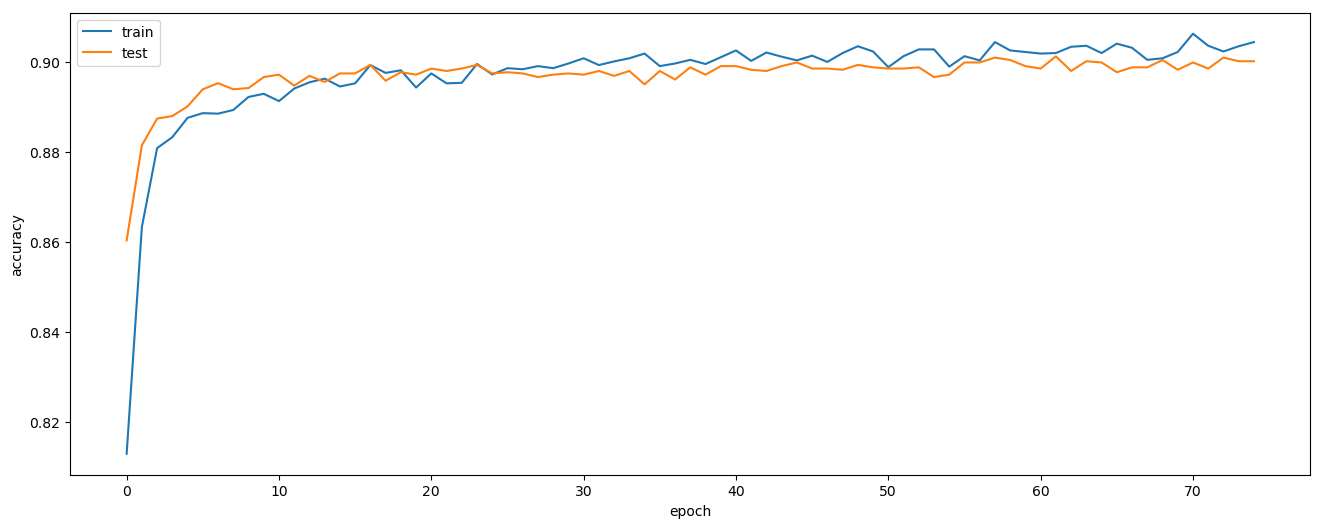

In [19]:
## plot results for model

import matplotlib.pyplot as plt

fig, ax  = plt.subplots(figsize=(16,6))
ax.plot(model_history.history['acc'])
ax.plot(model_history.history['val_acc'])
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend(['train', 'test'])

plt.show()

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [21]:
preds = model.predict_classes(X_test)

In [22]:
print(f"Accuracy: {round(accuracy_score(y_test, preds)*100,2)}%")

Accuracy: 90.02%


In [23]:
print(confusion_matrix(y_test, preds))

[[2990  129]
 [ 239  329]]


In [24]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3119
           1       0.72      0.58      0.64       568

    accuracy                           0.90      3687
   macro avg       0.82      0.77      0.79      3687
weighted avg       0.89      0.90      0.90      3687



In [25]:
sample_input=df.values[1,:-1]

In [26]:
sample_input[10]

'Feb'

In [27]:
## function for data processing
def prepare_data(input_data):
    
    ## encode 'Month' and 'Weekend'
    label_encoder = LabelEncoder()
    
    label_encoder.fit(df.values[:,10])
    input_data[[10]] = label_encoder.transform(input_data[[10]])
    
    label_encoder.fit(df.values[:,16])
    input_data[[16]] = label_encoder.transform(input_data[[16]])
    
    ## encode 'VisitorType'
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [15])], remainder='passthrough')
    ct.fit(df.values[:,:-1])
    input_data = ct.transform([input_data])
    
    ##scaling
    input_data = ss.transform(input_data)
    
    return input_data

In [28]:
## function to give predictions
def predict(model, input_data):
    
    prepared_input = prepare_data(input_data)
    
    result = model.predict_classes(prepared_input)
    
    if result[0][0] == 1:
        print(f"Predicted output: {True}")
    else:
        print(f"Predicted output: {False}")

In [29]:
## random test

random_row = np.random.randint(0,df.shape[0])

random_input = df.values[random_row, :-1]

print(f"Input: {random_input}")

true_output = df.values[random_row, -1]

print(f"True output: {true_output}")

Input: [6 110.625 1 106.0 30 1508.521825 0.04 0.043294931 21.01746974 0.0 'Nov' 3
 2 3 13 'Returning_Visitor' False]
True output: False


In [30]:
predict(model=model, input_data=random_input)

Predicted output: False


In [31]:
tf.keras.models.save_model(model, 'Churn_ANN_batchsize512_epochs75.h5')